### Enforcing Fairness in CelebA

This code demonstrates how to enforce fairness when working with deep neural networks in computer vision. Specifically we demonstrate how different notions of fairness and performance can be measured and enforced with our toolkit.

The protected attribute is Male. The user can specify what target attribute (e.g., Wearing_Earrings) that they would like to consider. 

In [1]:
!pip install git+https://github.com/ChrisMRuss/oxon-fair.git


  Running command git clone -q https://github.com/ChrisMRuss/oxon-fair.git 'C:\Users\sgoethals\AppData\Local\Temp\pip-req-build-i_yaudp8'



  Cloning https://github.com/ChrisMRuss/oxon-fair.git to c:\users\sgoethals\appdata\local\temp\pip-req-build-i_yaudp8
  Resolved https://github.com/ChrisMRuss/oxon-fair.git to commit 7098c670f9ad92d6f7b9fe794fbf257c2ef6f6f9


In [2]:
!pip show oxonfair

Name: oxonfair
Version: 0.1.5
Summary: AutoML Framework for evaluating and enforcing ML model fairness
Home-page: https://github.com/ChrisMRuss/oxon-fair/
Author: Governance of Emerging Technologies Programme (Oxford Internet Insitute)
Author-email: 
License: Apache-2.0
Location: c:\users\sgoethals\anaconda3\lib\site-packages
Requires: numpy, pandas
Required-by: 


In [26]:
import numpy as np 
import oxonfair
from oxonfair.utils import group_metrics as gm
from matplotlib import pyplot as plt

In [4]:
def get_all_celeba_attributes():
    return ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
            'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
            'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
            'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
            'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

In [1]:
validation_labels = np.load(r'Celeba_results\all_attributes_val_labels.npy') #loading the validation labels for all attributes
test_labels = np.load(r'Celeba_results\all_attributes_test_labels.npy') #loading the test labels for all attributes

validation_outputs = np.load(r'Celeba_results\All_Attributes_outputs_val.npy') # loading the corresponding outputs 
test_outputs = np.load(r'Celeba_results\All_Attributes_outputs_test.npy')

NameError: name 'np' is not defined

In [6]:
np.column_stack((validation_outputs[:,34], validation_outputs[:,20]))

array([[-3.72390795, -0.04863382],
       [-6.71334314,  1.003914  ],
       [-5.54749012,  0.01078447],
       ...,
       [-1.99252629, -0.03643667],
       [ 0.69160038, -0.02428942],
       [-4.78321409,  0.98419327]])

In [7]:
protected_attribute_index = get_all_celeba_attributes().index('Male')
target_attribute_index = get_all_celeba_attributes().index('Wearing_Earrings')

In [8]:
val = np.column_stack((validation_outputs[:,target_attribute_index], validation_outputs[:,20]))
val_target = validation_labels[:,target_attribute_index]
val_groups = validation_labels[:,protected_attribute_index]

test = np.column_stack((test_outputs[:,target_attribute_index], test_outputs[:,20]))
test_target = test_labels[:,target_attribute_index]
test_groups = test_labels[:,protected_attribute_index]

In [9]:
from collections import Counter
Counter(test_target)

Counter({1: 4125, 0: 15837})

In [10]:
#Helper functions.
#We assume that classifiers return multiple scores roughly lying in [0,1].
#To make this happen,we push logits through a sigmoid, and for square outputs we return them, and 1- them
def sigmoid(array):
    return np.stack ((1/(1+np.exp(array[:,0])),1/(1+np.exp(-array[:,0]))),1)
def square_align(array):
    return np.stack((array[:,1],1-array[:,1]),1)

In [11]:
val_dict={'data':val, 'target':val_target, 'groups':val_groups}
test_dict={'data':test,'target':test_target,'groups':test_groups}

### Enforcing Fairness

In [40]:
# target attribute index = 34 - wear earringsi
import numpy as np
import pandas as pd

# Load the numpy file
output_val = np.load('All_Attributes_outputs_val.npy')
output_test = np.load('All_Attributes_outputs_test.npy')
# Print the first items
print(output_val[:,target_attribute_index])
#plt.hist((output[:,target_attribute_index]), bins=100)

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

prediction_scores = sigmoid(output_val[:, target_attribute_index])
print(prediction_scores)


val_results, test_results=pd.DataFrame(), pd.DataFrame()
val_results['protected']=np.load('all_attributes_val_labels.npy')[:,protected_attribute_index].astype(bool)
val_results['target']=np.load('all_attributes_val_labels.npy')[:,target_attribute_index].astype(bool)
val_results['biased_scores']=prediction_scores
val_results['biased_label']=(prediction_scores>0.5).astype(int)
test_results['protected']=np.load('all_attributes_test_labels.npy')[:,protected_attribute_index]
test_results['target']=np.load('all_attributes_test_labels.npy')[:,target_attribute_index]
test_results['biased_scores']=sigmoid(output_test[:, target_attribute_index])
test_results['biased_label']=(sigmoid(output_test[:, target_attribute_index])>0.5).astype(int)
good_outcome=1 #wears earrings (being male is protected)


[-3.72390795 -6.71334314 -5.54749012 ... -1.99252629  0.69160038
 -4.78321409]
[0.02357047 0.00121312 0.0038821  ... 0.11998985 0.66632285 0.0082996 ]


In [29]:
#base rate
print(test_results.target.value_counts(normalize=True)[good_outcome])
print(test_results[test_results.protected==True].target.value_counts(normalize=True))
print(test_results[test_results.protected==False].target.value_counts(normalize=True))
print(test_results.protected.value_counts(normalize=True))
print('The base rate disparity is {}'.format(test_results[test_results.protected==False].target.value_counts(normalize=True)[good_outcome] - test_results[test_results.protected==True].target.value_counts(normalize=True)[good_outcome]))


0.20664262097986175
target
0    0.97641
1    0.02359
Name: proportion, dtype: float64
target
0    0.678044
1    0.321956
Name: proportion, dtype: float64
protected
0    0.613516
1    0.386484
Name: proportion, dtype: float64
The base rate disparity is 0.29836598918957025


In [43]:
%run "C:\Users\sgoethals\Documents\Research\Project Oxford\unfairness_fairml\Unfair_ML\functions\clean_functions.py"

In [44]:
test_metrics= run_all_results_clean(test_results, val_results, good_outcome)

Calculate demographic parity


100%|██████████| 100/100 [40:27<00:00, 24.28s/it]  


Calculate equality of opportunity


100%|██████████| 100/100 [14:31:06<00:00, 522.67s/it] 


Calculate precision


100%|██████████| 100/100 [00:02<00:00, 33.99it/s]


Calculate recall


100%|██████████| 100/100 [00:01<00:00, 54.37it/s]


In [50]:
%run "C:\Users\sgoethals\Documents\Research\Project Oxford\unfairness_fairml\Unfair_ML\functions\visualisations.py"

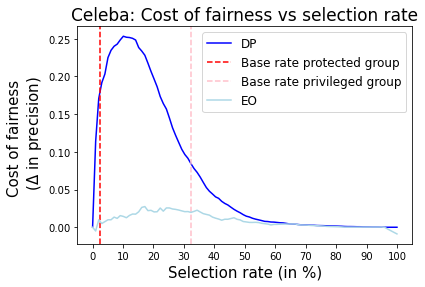

In [51]:
dataset='Celeba'
C_list=[i for i in np.linspace(start=1, stop=len(test_results), num=100, dtype=int)]

plot_cost(test_metrics['prec_unfair'],test_metrics['prec_dp'],C_list, test_results, 'precision', 'DP', dataset, test_metrics['prec_eo'], 'EO')    


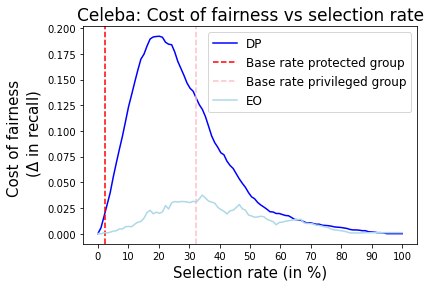

In [52]:

plot_cost(test_metrics['rec_unfair'],test_metrics['rec_dp'],C_list, test_results, 'recall', 'DP', dataset, test_metrics['rec_eo'], 'EO')    


In [49]:
#save results
import pickle
with open('Results/celeba/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)
with open('Results/celeba/test_metrics.pkl', 'wb') as f:
    pickle.dump(test_metrics, f)


In [46]:
from sklearn.metrics import roc_auc_score
print('The AUC of the biased model (validation set) is:', roc_auc_score(val_results.target,val_results.biased_scores))
print('The AUC of the biased model (test set) is:', roc_auc_score(test_results.target,test_results.biased_scores))
print('The AUC of the biased model for the protected group (test set) is:', roc_auc_score(test_results[test_results.protected==True].target,test_results[test_results.protected==True].biased_scores))
print('The AUC of the biased model for the privileged group (test set) is:', roc_auc_score(test_results[test_results.protected==False].target,test_results[test_results.protected==False].biased_scores))
print('The base rate disparity is {}'.format(val_results[val_results.protected==False].target.value_counts(normalize=True)[good_outcome] - val_results[val_results.protected==True].target.value_counts(normalize=True)[good_outcome]))
print('The average cost of fairness (DP) is {}'.format(mean([a - b for a, b in zip(test_metrics['prec_unfair'], test_metrics['prec_dp'])])))
print('The average cost of fairness (EO) is {}'.format(mean([a - b for a, b in zip(test_metrics['prec_unfair'], test_metrics['prec_eo'])])))
print('The average cost of fairness (DP) is {}'.format(mean([a - b for a, b in zip(test_metrics['rec_unfair'], test_metrics['rec_dp'])])))
print('The average cost of fairness (EO) is {}'.format(mean([a - b for a, b in zip(test_metrics['rec_unfair'], test_metrics['rec_eo'])])))

The AUC of the biased model (validation set) is: 0.9654979842100586
The AUC of the biased model (test set) is: 0.9567146364191259
The AUC of the biased model for the protected group (test set) is: 0.9692532344862095
The AUC of the biased model for the privileged group (test set) is: 0.9314896475156335
The base rate disparity is 0.3098710449187388
The average cost of fairness (DP) is 0.06894233583894206
The average cost of fairness (EO) is 0.00890394036517542
The average cost of fairness (DP) is 0.061796363636363635
The average cost of fairness (EO) is 0.013343030303030296


### Fitzpatrick-17k Example